# Generated Content Detector Project: AI generated photos vs real photos - Version 3


### Import libraries

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import os
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
print(torch.cuda.is_available())
from PIL import Image

True


### Mount Google Drive

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Determine System Device to optimize performance: CPU or CUDA (VRAM) Checker

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


### Image Dataset Preparation with PyTorch
##### - Training Data: 7,000 images (3500 AI + 3500 real) - 70%
##### - Testing Data: 2,000 images (1000 AI + 1000 real) - 20%
##### - Testing Data: 1,000 images (500 AI + 500 real) - 10%

In [41]:
%%time
# Set up image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset from the specified directory
dataset = datasets.ImageFolder("/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v3/AI-face-detection-Dataset-v3/", transform=transform)

# dataset.class_to_idx → {'ai': 0, 'real': 1}

# Split by class (real + ai separately)
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 70%, Validation size 10%, Test size 20%
def split_class(indices, train_ratio=0.7, val_ratio=0.1):
    train_len = int(len(indices) * train_ratio)
    val_len = int(len(indices) * val_ratio)
    return indices[:train_len], indices[train_len:train_len + val_len], indices[train_len + val_len:]

train_real, val_real, test_real = split_class(indices_real)
train_ai, val_ai, test_ai = split_class(indices_ai)

# Combine training, validation, and testing indices
train_indices = train_real + train_ai
val_indices = val_real + val_ai
test_indices = test_real + test_ai

# Prepare subsets for training, validation, and testing
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for batch processing
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)  # Validation loader
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Retrieve class names
classes = dataset.classes   # ['ai', 'real']

# Output the number of samples in training, validation, and testing datasets
print("Train samples:", len(train_indices))
print("Validation samples:", len(val_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

Train samples: 6996
Validation samples: 998
Test samples: 2002
Classes: ['AI', 'real_color']
CPU times: user 11min 11s, sys: 4.55 s, total: 11min 15s
Wall time: 3min 46s


### Display Randomly Selected Images with Classifications from the Trained Model

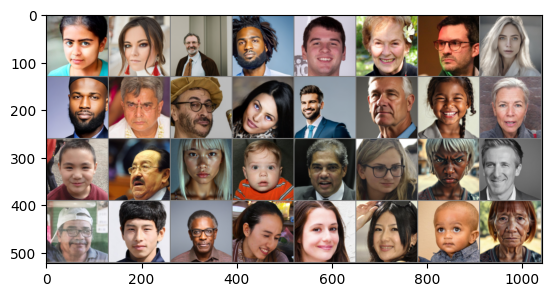

Train Labels: AI    AI    AI    AI    real_color real_color real_color AI   


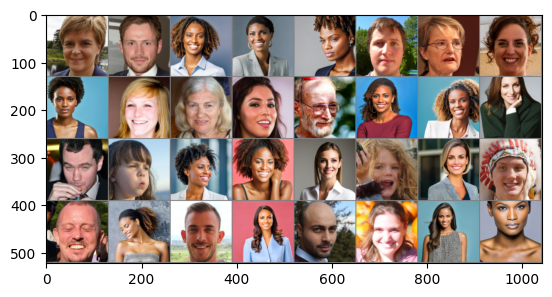

Validation Labels: real_color real_color AI    AI    AI    real_color real_color real_color


In [42]:
# Functions to display an image
batch_size = 8
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Fetch some random training images
dataiter_train = iter(trainloader)
images_train, labels_train = next(dataiter_train)

# Display the training images
imshow(torchvision.utils.make_grid(images_train))

# Print the corresponding training labels
print('Train Labels: ' + ' '.join(f'{classes[labels_train[j]]:5s}' for j in range(batch_size)))

# Fetch some random validation images
dataiter_val = iter(valloader)
images_val, labels_val = next(dataiter_val)

# Display the validation images
imshow(torchvision.utils.make_grid(images_val))

# Print the corresponding validation labels
print('Validation Labels: ' + ' '.join(f'{classes[labels_val[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network (CNN) for Image Classification
##### This code implements a convolutional neural network (CNN) class named Net, featuring two convolutional layers with pooling, followed by three fully connected layers. It is designed for binary image classification, effectively modeling the forward pass to process input images and output class predictions.

In [43]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer
        self.conv2 = nn.Conv2d(6, 16, 5) # Second convolutional layer
        # Flattened size: 16 channels * 29 * 29 (for fully connected layer)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # First fully connected layer
        self.fc2 = nn.Linear(120, 84) # Second fully connected layer
        self.fc3 = nn.Linear(84, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Apply first conv layer and pooling
        x = self.pool(F.relu(self.conv2(x))) # Apply second conv layer and pooling
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # Forward pass through first fully connected layer
        x = F.relu(self.fc2(x)) # Forward pass through second fully connected layer
        x = self.fc3(x) # Output layer
        return x


# net = Net()             # Use this for CPU
net = Net().to(device)    # Move the model to GPU

### Define a Loss function and optimizer

In [44]:
# Define the loss function for training
criterion = nn.CrossEntropyLoss() # This is used for multi-class classification

# Set up the optimizer for updating the model's parameters
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent with momentum

# Alternative optimizer (commented out): Adam optimizer for adaptive learning rate
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Training the Neural Network
##### This section of the code trains a neural network for image classification 100 epochs, calculating and recording the training loss at each epoch. The process utilizes a data loader to iterate through the training dataset, performs forward passes to compute outputs, calculates the loss using a defined criterion, performs backward passes to compute gradients, and updates the model weights using the specified optimizer.


In [45]:
%%time
train_losses = []
val_losses = []  # List to store validation losses

# Loop through a specified number of epochs
for epoch in range(100):
    running_loss = 0.0  # Initialize cumulative loss for the current epoch

    # Iterate through the training data
    for i, data in enumerate(trainloader):
        inputs, labels = data  # Get the input images and their corresponding labels

        inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
        labels = labels.to(device)  # Move labels to the device

        optimizer.zero_grad()  # Clear previous gradients

        outputs = net(inputs)  # Forward pass: compute the model's predictions

        loss = criterion(outputs, labels)  # Compute the training loss

        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the training loss

    epoch_loss = running_loss / len(trainloader)  # Average loss for the epoch
    train_losses.append(epoch_loss)  # Store the epoch loss
    print(f"Epoch {epoch+1}, Training loss: {epoch_loss:.4f}")  # Print the training loss for the current epoch

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0  # Initialize cumulative validation loss

    with torch.no_grad():  # Disable gradient calculation for validation
        for data in valloader:
            inputs, labels = data  # Get the validation images and labels
            inputs = inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

            outputs = net(inputs)  # Forward pass: compute predictions
            loss = criterion(outputs, labels)  # Compute validation loss
            val_running_loss += loss.item()  # Accumulate validation loss

    val_epoch_loss = val_running_loss / len(valloader)  # Average validation loss for the epoch
    val_losses.append(val_epoch_loss)  # Store the validation loss
    print(f"Epoch {epoch+1}, Validation loss: {val_epoch_loss:.4f}")  # Print validation loss

print("Finished Training")  # Indicate the training process is complete


Epoch 1, Training loss: 0.6161
Epoch 1, Validation loss: 0.3624
Epoch 2, Training loss: 0.3073
Epoch 2, Validation loss: 0.2641
Epoch 3, Training loss: 0.2403
Epoch 3, Validation loss: 0.2326
Epoch 4, Training loss: 0.2007
Epoch 4, Validation loss: 0.1459
Epoch 5, Training loss: 0.1579
Epoch 5, Validation loss: 0.1095
Epoch 6, Training loss: 0.1333
Epoch 6, Validation loss: 0.0959
Epoch 7, Training loss: 0.1240
Epoch 7, Validation loss: 0.0976
Epoch 8, Training loss: 0.0996
Epoch 8, Validation loss: 0.1113
Epoch 9, Training loss: 0.0867
Epoch 9, Validation loss: 0.0905
Epoch 10, Training loss: 0.0821
Epoch 10, Validation loss: 0.0800
Epoch 11, Training loss: 0.0654
Epoch 11, Validation loss: 0.0877
Epoch 12, Training loss: 0.0608
Epoch 12, Validation loss: 0.0923
Epoch 13, Training loss: 0.0461
Epoch 13, Validation loss: 0.1266
Epoch 14, Training loss: 0.0386
Epoch 14, Validation loss: 0.0910
Epoch 15, Training loss: 0.0362
Epoch 15, Validation loss: 0.1006
Epoch 16, Training loss: 0.0

### Visualizing Training Results:
###### The training loss graph indicates a rapid decrease in loss during the initial epochs, demonstrating effective learning. It quickly stabilizes, suggesting convergence towards an optimal performance. The extended plateau at a low loss level implies the model is maintaining its performance without signs of overfitting. Overall, this reflects efficient training progress.

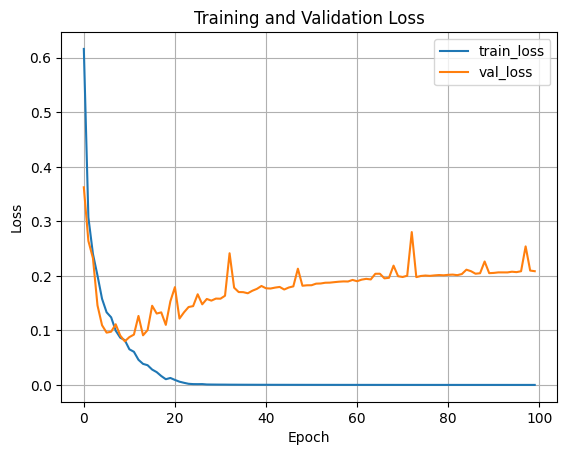

In [46]:
def plot_history(train_losses, val_losses):
    plt.figure()  # Create a new figure for the plot
    plt.plot(train_losses, label="train_loss")  # Plot the training losses
    plt.plot(val_losses, label="val_loss")      # Plot the validation losses
    plt.xlabel("Epoch")                         # Label for the x-axis
    plt.ylabel("Loss")                          # Label for the y-axis
    plt.title("Training and Validation Loss")   # Title of the plot
    plt.grid(True)                              # Add a grid for better readability
    plt.legend()                                # Show the legend on the plot
    plt.show()                                  # Display the plot

# Check if 'train_losses' and 'val_losses' exist and are not empty before plotting
if 'train_losses' in globals() and train_losses and 'val_losses' in globals() and val_losses:
    plot_history(train_losses, val_losses)  # Call the plotting function with training and validation losses
else:
    print("Error: 'train_losses' or 'val_losses' not found or is empty. Please run the training cell first.")  # Error message if the lists are unavailable


###### The graph shows a sharp decline in training loss during the initial epochs, indicating effective learning. By around the 20th epoch, the loss stabilizes at a low level, suggesting convergence and consistent model performance.

### Saving the Trained Model


In [47]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v3/ai_real_net_v4.pth' # added validation to this model compared to version 3
torch.save(net.state_dict(), PATH)

### Testing the Network on Test Data
###### The code initializes a test data iterator, retrieves a batch of test images and their labels, and displays the images while printing the corresponding ground truth labels.


Test Data Iterator: <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7b1522ef9700>


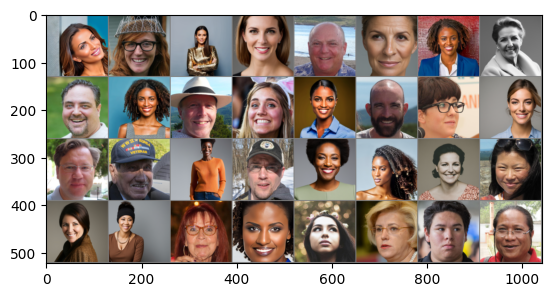

GroundTruth:  AI    real_color AI    AI    real_color AI    AI    AI   


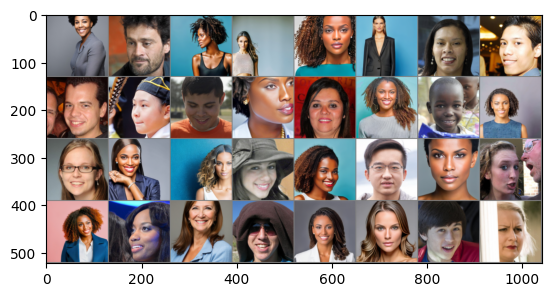

Validation GroundTruth:  AI    real_color AI    AI    AI    AI    real_color real_color


In [48]:
# Test Data Visualization
dataiter_test = iter(testloader)  # Create an iterator for the test data loader
print("Test Data Iterator:", dataiter_test)  # Print the iterator object for reference
images_test, labels_test = next(dataiter_test)  # Get a batch of test images and their corresponding labels

# Display the test images using the defined imshow function
imshow(torchvision.utils.make_grid(images_test))

# Print the ground truth labels for the displayed test images
print('GroundTruth: ', ' '.join(f'{classes[labels_test[j]]:5s}' for j in range(8)))

# Optionally, visualize validation images
dataiter_val = iter(valloader)  # Create an iterator for the validation data loader
images_val, labels_val = next(dataiter_val)  # Get a batch of validation images and their corresponding labels

# Display the validation images using the defined imshow function
imshow(torchvision.utils.make_grid(images_val))

# Print the ground truth labels for the displayed validation images
print('Validation GroundTruth: ', ' '.join(f'{classes[labels_val[j]]:5s}' for j in range(8)))

### Loading the Saved Model and Summary of Architecture
##### The code loads the saved model and generates a summary of its architecture, revealing approximately 1.63 million trainable parameters with no non-trainable parameters. It details the output shapes for each layer, including two convolutional layers followed by pooling and three fully connected layers. This information is crucial for understanding the model's complexity and resource requirements, indicating its potential computational demands.

In [49]:
# Define the path where the model is saved
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v3/ai_real_net_v4.pth'

# Initialize the neural network model
net = Net()

# Load the model's weights from the specified path
net.load_state_dict(torch.load(PATH, map_location=device))  # Specify map_location for compatibility

# Move the model to the appropriate device
net.to(device)

# Set the model to evaluation mode
net.eval()  # Important for layers like dropout and batch normalization if they are present

# Display a summary of the model architecture with the corrected input size
summary(net, (3, 128, 128))  # Display the model summary for input size of (3, 128, 128)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
         MaxPool2d-2            [-1, 6, 62, 62]               0
            Conv2d-3           [-1, 16, 58, 58]           2,416
         MaxPool2d-4           [-1, 16, 29, 29]               0
            Linear-5                  [-1, 120]       1,614,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 1,628,046
Trainable params: 1,628,046
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.39
Params size (MB): 6.21
Estimated Total Size (MB): 7.79
----------------------------------------------------------------


### Interpreting Model Outputs: Class Predictions
##### The outputs from the model indicate the predicted class labels for the given images. In this case, the model predicts three instances as "AI" and one as "real." This reflects the network's classifications for the input images, showing which class it believes each image belongs to.

In [50]:
# Assuming you have run the model on a batch of images
dataiter = iter(testloader)  # Create an iterator for test data
images, labels = next(dataiter)  # Get a batch of test images and their labels
images = images.to(device)  # Move images to the device
net.eval()  # Set the model to evaluation mode

# Forward pass through the network to get outputs
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = net(images)  # Get model predictions

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Print the predicted labels for the first few images in the batch
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(min(4, len(predicted)))))


Predicted:  real_color real_color AI    AI   


### Evaluating Network Performance on the Entire Dataset
###### This section evaluates the network's performance on the entire test dataset. It iterates through the test data, calculates the model's predictions, and counts the number of correct classifications. Finally, it computes and displays the accuracy of the network on the test images, providing insight into its effectiveness on unseen data.

In [51]:
correct = 0  # Initialize a counter for correctly classified images
total = 0    # Initialize a counter for the total number of images

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:  # Iterate through batches of test data
        images, labels = data  # Get images and their corresponding labels

        # Move inputs to the appropriate device for processing
        images = images.to(device)
        labels = labels.to(device)

        # Calculate outputs by passing images through the network
        outputs = net(images)

        # Determine the predicted class by finding the index of the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  # Update the total number of images processed
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print the accuracy of the network on the test dataset
accuracy = 100 * correct / total if total > 0 else 0  # Prevent division by zero
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')  # Print accuracy formatted to two decimal places

Accuracy of the network on the test images: 97.55 %


###### This section evaluates the network's performance per class by counting correct and total predictions, then calculates and displays accuracy for each class in the test dataset:

In [53]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move inputs to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: AI    is 97.6 %
Accuracy for class: real_color is 97.5 %


### Evaluating Model Performance on an Out-of-Dataset Image:
###### This code defines the model architecture and includes functions to load a trained model, preprocess an input image, and predict its class based on the model's outputs. It enables evaluating the model on any image not present in the original dataset, allowing for insights into the model's generalization capabilities. The pipeline processes the specified image, performs inference, and prints the prediction results along with class probabilities, providing a clear understanding of the model's performance on unseen data.

In [63]:
# Step 1: Define the EXACT model architecture from training
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer
        self.conv2 = nn.Conv2d(6, 16, 5) # Second convolutional layer
        # Flattened size: 16 channels * 29 * 29 (for fully connected layer)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # First fully connected layer
        self.fc2 = nn.Linear(120, 84) # Second fully connected layer
        self.fc3 = nn.Linear(84, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Apply first conv layer and pooling
        x = self.pool(F.relu(self.conv2(x))) # Apply second conv layer and pooling
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # Forward pass through first fully connected layer
        x = F.relu(self.fc2(x)) # Forward pass through second fully connected layer
        x = self.fc3(x) # Output layer
        return x

# Step 2: Load the trained model
def load_model(model_path, device='cpu'):
    """Load the trained model from .pth file"""
    model = Net().to(device)  # Initialize model and move to specified device
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load the model's weights
    model.eval()  # Set the model to evaluation mode
    return model

# Step 3: Preprocess the image (CRITICAL: Must be 128x128!)
def preprocess_image(image_path, target_size=(128, 128)):
    """Load and preprocess a single image"""
    # Define transforms - adjust normalization if you used different values during training
    transform = transforms.Compose([
        transforms.Resize(target_size),  # Resize image to target size
        transforms.ToTensor(),           # Convert image to tensor
        # If you used normalization during training, add it here:
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load the image and apply the transformations
    image = Image.open(image_path).convert('RGB')  # Open and convert image to RGB
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Step 4: Make prediction
def predict(model, image_tensor, device='cpu'):
    """Run inference on the preprocessed image"""
    image_tensor = image_tensor.to(device)  # Move tensor to the appropriate device

    with torch.no_grad():  # Disable gradient computation
        outputs = model(image_tensor)  # Get model outputs
        probabilities = torch.softmax(outputs, dim=1)  # Convert outputs to probabilities
        predicted_class = torch.argmax(probabilities, dim=1)  # Get the predicted class index

    return predicted_class.item(), probabilities[0].cpu().numpy()  # Return predictions


# Step 5: Main testing function
def test_single_image(model_path, image_path, class_labels=None, device=None):
    """Complete pipeline to test model on a single image"""
    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Default class labels (adjust based on your training)
    if class_labels is None:
        class_labels = {
            0: "Class 0",  # AI
            1: "Class 1",  # Real
        }

         # Load model
    print(f"Loading model from {model_path}...")
    model = load_model(model_path, device)

    # Preprocess image
    print(f"Processing image: {image_path}")
    image_tensor = preprocess_image(image_path)

    # Make prediction
    print("Running inference...")
    predicted_class, probabilities = predict(model, image_tensor, device)

    # Display results
    print("\n" + "="*60)
    print("RESULTS:")
    print("="*60)
    print(f"Predicted Class: {class_labels.get(predicted_class, f'Class {predicted_class}')} (Class {predicted_class})")
    print(f"\nProbabilities:")
    for i, prob in enumerate(probabilities):
        label = class_labels.get(i, f"Class {i}")
        print(f"  {label}: {prob:.4f} ({prob*100:.2f}%)")
    print("="*60)

    return predicted_class, probabilities


# Example usage
if __name__ == "__main__":
    # Define your class labels (IMPORTANT: Replace these with your actual class names)
    # Make sure you have exactly 3 labels since your model has 3 output classes
    CLASS_LABELS = {
        0: "AI-Generated",
        1: "Real Photo",

    }

    # Paths
    MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v3/ai_real_net_v4.pth"
    IMAGE_PATH = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v3/photos_outside_dataset/real_1.avif"

    # Run test
    try:
        predicted_class, probabilities = test_single_image(
            MODEL_PATH,
            IMAGE_PATH,
            class_labels=CLASS_LABELS
        )

        print(f"Prediction complete!")
        print(f"The image is classified as: {CLASS_LABELS[predicted_class]}")

    except FileNotFoundError as e:
        print(f" Error: {e}")
        print("Please check that the model and image paths are correct.")
    except Exception as e:
        print(f" An error occurred: {e}")
        import traceback
        traceback.print_exc()

Using device: cuda
Loading model from /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v3/ai_real_net_v4.pth...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_v3/photos_outside_dataset/real_1.avif
Running inference...

RESULTS:
Predicted Class: Real Photo (Class 1)

Probabilities:
  AI-Generated: 0.1904 (19.04%)
  Real Photo: 0.8096 (80.96%)
Prediction complete!
The image is classified as: Real Photo


##### CONCLUSION: The model has shown significant improvement in its performance on out-of-dataset images, correctly recognizing 3 out of 9 real photos, compared to 0 previously. Accuracy on AI generated out-of-dataset images is 100%. While the model achieves 98% average accuracy on the test dataset, this enhancement underscores the importance of dataset expansion even further to continue to enhance the model's robustness and accuracy in classifying both familiar and external images.

##### Note: Real photos should be unedited and in their raw format, free from any Photoshop manipulation.